6. Kaggle2_RoBERTa_Transfer_learning_Classification
•	Finetuned RoBERTa on Data2 children


- Soo Kyung Bae(Scarlett), Ph.D. Student
- Dept. of Integrated Medicine(Major in Digital Healthcare)
- Yonsei University College of Medicine

In [1]:
# 1. 라이브러리 및 데이터 불러오기

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import random
from sklearn.model_selection import train_test_split
from transformers import Trainer
from transformers import TrainingArguments
from transformers import RobertaTokenizerFast
from transformers import RobertaForSequenceClassification
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
import seaborn as sns



/opt/anaconda3/envs/RoBERTa/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 데이터 불러오기

# preprocessed Kagge2 data
data_total = pd.read_csv('./output/ASD_CSV_T_ASD2_Feb23.csv')
data_total=data_total[['ASD_traits','text']] # # 데이터셋에서 Class/ASD Traits 와 text column만 사용
data_total.columns =['label','text']

ASD_mapping = {
    'No': 0, # TD
    'Yes' : 1, # ASD
}

data_total['label'] = data_total['label'].replace(ASD_mapping)
data_total.label.value_counts()

FileNotFoundError: [Errno 2] No such file or directory: './output/ASD_CSV_T_ASD2_Feb23.csv'

In [ ]:
# 시드값 설정

#set random seed 
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    # torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
random_seed = 42
set_seed(random_seed)

In [ ]:
# 2. train-validation-test split

In [ ]:
# X: input variables, y: target variable
X = data_total.drop('label', axis=1)
y = data_total['label']

# train-test split(7:3)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# Combine X_train and y_train, and reset the index
train_and_validation_data = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)

# Combine X_test and y_test, and reset the index
test_data = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

# train-validation split(8:2)

# X: input variables, y: target variable
X = train_and_validation_data.drop('label', axis=1)
y = train_and_validation_data['label']

# Split the data into training and test sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

train_data = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
valid_data = pd.concat([X_valid, y_valid], axis=1).reset_index(drop=True)


In [ ]:
print("size of train dataset: ", len(train_data))
print("size of validation dataset: ", len(valid_data))
print("size of test dataset: ", len(test_data))

size of train dataset:  1111
size of validation dataset:  278
size of test dataset:  596


In [ ]:
# 3. Tokenization 

In [ ]:
# Tokenizatino에 사용할 tokenizer model 불러오리
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

# Tokenize the dataset (with attention mask)
encodings = tokenizer(train_data['text'].tolist(), truncation=True, padding=True, max_length=512)
train_labels = train_data['label'].tolist()
train_input_ids = encodings['input_ids'] # Extract 'input_ids' from the encodings
train_attention_masks = encodings['attention_mask'] # Extract 'attention_mask' from the encodings

# Tokenize the dataset (with attention mask)
encodings = tokenizer(valid_data['text'].tolist(), truncation=True, padding=True, max_length=512)
valid_labels = valid_data['label'].tolist()
valid_input_ids = encodings['input_ids'] # Extract 'input_ids' from the encodings
valid_attention_masks = encodings['attention_mask'] # Extract 'attention_mask' from the encodings

# Tokenize the dataset (with attention mask)
encodings = tokenizer(test_data['text'].tolist(), padding=True, truncation=True, return_tensors="pt")
test_input_ids = encodings['input_ids'] # Extract 'input_ids' from the encodings
test_attention_masks = encodings['attention_mask'] # Extract 'attention_mask' from the encodings

In [ ]:
# Before
print("text example from train BEFORE tokenization: ")
print(train_data['text'][0])

text example from train BEFORE tokenization: 
attention and concentration deficit , , , , , ,social interaction impairment in social/emotional reciprocity , ,difficulty imitating gesture ,


In [ ]:
# After
print("text example from train AFTER tokenization: ")
print("Input Ids: ", train_input_ids[0])
print("attention mask: ", train_attention_masks[0])

text example from train AFTER tokenization: 
Input Ids:  [0, 2611, 19774, 8, 11772, 3781, 2156, 2156, 2156, 2156, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 32278, 48284, 4356, 22257, 12433, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
attention mask:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
# 4. New dataset class for Training Process

In [ ]:
# training에 사용하기 위해 데이터 타입 전환

# Training에 사용될 데이터 class
class QCHATDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __getitem__(self, idx):
        # training 과정에서 데이터가 사용될 때 tensor 타입으로 사용되도록 합니다. 
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

    def __len__(self):
        return len(self.labels)

# Create training and validation datasets
train_dataset = QCHATDataset(train_input_ids, train_attention_masks, train_labels)
valid_dataset = QCHATDataset(valid_input_ids, valid_attention_masks, valid_labels)
# test dataset
test_dataset = QCHATDataset(test_input_ids, test_attention_masks, test_data['label'].tolist())


In [ ]:
# After
train_dataset[0]

{'input_ids': tensor([    0,  2611, 19774,     8, 11772,  3781,  2156,  2156,  2156,  2156,
          2156,  2156, 19027, 10405, 18741,    11,   592,    73,   991, 23745,
         31516,  1571,  2156,  2156, 32278, 48284,  4356, 22257, 12433,  2156,
             2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor(0)}

In [ ]:
# 5. Model Build and Fine-Tuning

In [ ]:

# Load the pre-trained RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('./output/Roberta/ROBERTA_qchatmodel_score_edited', num_labels=2)

# Training에 사용될 hyperparameter을 설정해줍니다.
training_args1 = TrainingArguments(
    output_dir='./results_ASD2',
    per_device_train_batch_size = 8,  # batch size for training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=0,                # number of warmup steps
    weight_decay=1e-8,               # strength of weight decay
    logging_dir='./log',            # directory for storing logs
    logging_steps=10,              # log saving step. 100
    evaluation_strategy="epoch",     # evaluate each `logging_steps`,
    learning_rate=3e-5,              # learning rate
)

/opt/anaconda3/envs/RoBERTa/lib/python3.9/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Training에 사용할 evaluation metrics를 설정해줍니다.

def compute_metrics_multiclass2(p, num_classes=2):  # num_classes is now set to 2
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    # Multiclass
    f1 = f1_score(labels, predictions, average='macro')
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)

     # Treat each class as a binary classification
    labels_binarized = label_binarize(labels, classes=range(num_classes))
    predictions_binarized = label_binarize(predictions, classes=range(num_classes))

    # Multiclass AUROC , Average Precision
    auroc = roc_auc_score(labels_binarized, predictions_binarized, multi_class='ovr')
    avgprc = average_precision_score(labels_binarized, predictions_binarized)

    return {
        "acc": acc, 
        "f1": f1, 
        "precision": precision, 
        "recall": recall, 
        "auroc": auroc, 
        "avgprc": avgprc
    }

def compute_metrics_wrapper(p):
    return compute_metrics_multiclass2(p, num_classes=2) #0,1


In [ ]:
# Training에 필요한 데이터셋, model, evaluation_metrics, hyperparameter 등을 주어줍니다.

trainer = Trainer(
    model=model,
    args=training_args1,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics_wrapper  # We will define compute_metrics function later
)
trainer.train() 

  2%|▏         | 10/417 [00:03<02:14,  3.03it/s]

{'loss': 0.7111, 'grad_norm': 12.18950080871582, 'learning_rate': 2.9280575539568346e-05, 'epoch': 0.07}


  5%|▍         | 20/417 [00:05<01:51,  3.55it/s]

{'loss': 0.5674, 'grad_norm': 3.351975917816162, 'learning_rate': 2.8561151079136692e-05, 'epoch': 0.14}


  7%|▋         | 30/417 [00:08<01:49,  3.52it/s]

{'loss': 0.492, 'grad_norm': 5.072478294372559, 'learning_rate': 2.7841726618705038e-05, 'epoch': 0.22}


 10%|▉         | 40/417 [00:11<01:46,  3.55it/s]

{'loss': 0.4659, 'grad_norm': 10.599614143371582, 'learning_rate': 2.7122302158273383e-05, 'epoch': 0.29}


 12%|█▏        | 50/417 [00:14<01:42,  3.57it/s]

{'loss': 0.5577, 'grad_norm': 5.005249977111816, 'learning_rate': 2.6402877697841725e-05, 'epoch': 0.36}


 14%|█▍        | 60/417 [00:16<01:25,  4.16it/s]

{'loss': 0.4448, 'grad_norm': 2.3389487266540527, 'learning_rate': 2.5683453237410074e-05, 'epoch': 0.43}


 17%|█▋        | 70/417 [00:19<01:45,  3.28it/s]

{'loss': 0.4225, 'grad_norm': 2.722849130630493, 'learning_rate': 2.496402877697842e-05, 'epoch': 0.5}


 19%|█▉        | 80/417 [00:22<01:39,  3.40it/s]

{'loss': 0.3247, 'grad_norm': 125.56720733642578, 'learning_rate': 2.4244604316546762e-05, 'epoch': 0.58}


 22%|██▏       | 90/417 [00:25<01:30,  3.62it/s]

{'loss': 0.6811, 'grad_norm': 9.773590087890625, 'learning_rate': 2.3525179856115108e-05, 'epoch': 0.65}


 24%|██▍       | 100/417 [00:28<01:37,  3.27it/s]

{'loss': 0.5408, 'grad_norm': 4.892734527587891, 'learning_rate': 2.2805755395683457e-05, 'epoch': 0.72}


 26%|██▋       | 110/417 [00:31<01:28,  3.45it/s]

{'loss': 0.453, 'grad_norm': 1.3465309143066406, 'learning_rate': 2.20863309352518e-05, 'epoch': 0.79}


 29%|██▉       | 120/417 [00:34<01:26,  3.44it/s]

{'loss': 0.4973, 'grad_norm': 19.55626106262207, 'learning_rate': 2.1366906474820145e-05, 'epoch': 0.86}


 31%|███       | 130/417 [00:37<01:19,  3.60it/s]

{'loss': 0.3608, 'grad_norm': 3.036679267883301, 'learning_rate': 2.064748201438849e-05, 'epoch': 0.94}


                                                 
 33%|███▎      | 139/417 [00:41<01:11,  3.89it/s]

{'eval_loss': 0.4705778658390045, 'eval_acc': 0.7733812949640287, 'eval_f1': 0.7692946058091287, 'eval_precision': 0.8096955128205128, 'eval_recall': 0.7805807622504537, 'eval_auroc': 0.7805807622504538, 'eval_avgprc': 0.7704762052427024, 'eval_runtime': 1.8366, 'eval_samples_per_second': 151.367, 'eval_steps_per_second': 19.057, 'epoch': 1.0}


 34%|███▎      | 140/417 [00:41<03:53,  1.19it/s]

{'loss': 0.5632, 'grad_norm': 5.559594631195068, 'learning_rate': 1.9928057553956836e-05, 'epoch': 1.01}


 36%|███▌      | 150/417 [00:44<01:26,  3.09it/s]

{'loss': 0.4013, 'grad_norm': 3.749439239501953, 'learning_rate': 1.920863309352518e-05, 'epoch': 1.08}


 38%|███▊      | 160/417 [00:48<01:21,  3.14it/s]

{'loss': 0.2312, 'grad_norm': 3.0610263347625732, 'learning_rate': 1.8489208633093527e-05, 'epoch': 1.15}


 41%|████      | 170/417 [00:50<01:12,  3.43it/s]

{'loss': 0.4595, 'grad_norm': 15.349417686462402, 'learning_rate': 1.776978417266187e-05, 'epoch': 1.22}


 43%|████▎     | 180/417 [00:53<01:08,  3.46it/s]

{'loss': 0.3248, 'grad_norm': 5.581786155700684, 'learning_rate': 1.7050359712230218e-05, 'epoch': 1.29}


 46%|████▌     | 190/417 [00:56<01:02,  3.60it/s]

{'loss': 0.5127, 'grad_norm': 5.629878997802734, 'learning_rate': 1.633093525179856e-05, 'epoch': 1.37}


 48%|████▊     | 200/417 [01:00<01:15,  2.89it/s]

{'loss': 0.3515, 'grad_norm': 0.9741497039794922, 'learning_rate': 1.5611510791366906e-05, 'epoch': 1.44}


 50%|█████     | 210/417 [01:03<01:04,  3.19it/s]

{'loss': 0.2396, 'grad_norm': 5.3457932472229, 'learning_rate': 1.4892086330935253e-05, 'epoch': 1.51}


 53%|█████▎    | 220/417 [01:06<00:56,  3.48it/s]

{'loss': 0.388, 'grad_norm': 1.2469028234481812, 'learning_rate': 1.4172661870503597e-05, 'epoch': 1.58}


 55%|█████▌    | 230/417 [01:08<00:49,  3.79it/s]

{'loss': 0.706, 'grad_norm': 73.70990753173828, 'learning_rate': 1.3453237410071943e-05, 'epoch': 1.65}


 58%|█████▊    | 240/417 [01:11<00:47,  3.70it/s]

{'loss': 0.5848, 'grad_norm': 3.2270233631134033, 'learning_rate': 1.2733812949640289e-05, 'epoch': 1.73}


 60%|█████▉    | 250/417 [01:14<00:46,  3.63it/s]

{'loss': 0.3526, 'grad_norm': 10.39188003540039, 'learning_rate': 1.2014388489208634e-05, 'epoch': 1.8}


 62%|██████▏   | 260/417 [01:17<00:42,  3.68it/s]

{'loss': 0.3068, 'grad_norm': 3.769768476486206, 'learning_rate': 1.1294964028776978e-05, 'epoch': 1.87}


 65%|██████▍   | 270/417 [01:20<00:44,  3.30it/s]

{'loss': 0.292, 'grad_norm': 4.954076290130615, 'learning_rate': 1.0575539568345324e-05, 'epoch': 1.94}


                                                 
 67%|██████▋   | 278/417 [01:24<00:39,  3.56it/s]

{'eval_loss': 0.4195903539657593, 'eval_acc': 0.7985611510791367, 'eval_f1': 0.79338535860275, 'eval_precision': 0.8518518518518519, 'eval_recall': 0.806896551724138, 'eval_auroc': 0.806896551724138, 'eval_avgprc': 0.8152319523691391, 'eval_runtime': 1.6341, 'eval_samples_per_second': 170.128, 'eval_steps_per_second': 21.419, 'epoch': 2.0}


 67%|██████▋   | 280/417 [01:24<01:26,  1.58it/s]

{'loss': 0.4978, 'grad_norm': 3.2645742893218994, 'learning_rate': 9.85611510791367e-06, 'epoch': 2.01}


 70%|██████▉   | 290/417 [01:27<00:40,  3.14it/s]

{'loss': 0.4159, 'grad_norm': 2.3799521923065186, 'learning_rate': 9.136690647482015e-06, 'epoch': 2.09}


 72%|███████▏  | 300/417 [01:30<00:36,  3.25it/s]

{'loss': 0.3454, 'grad_norm': 1.6327067613601685, 'learning_rate': 8.417266187050359e-06, 'epoch': 2.16}


 74%|███████▍  | 310/417 [01:33<00:30,  3.53it/s]

{'loss': 0.4199, 'grad_norm': 1.4594477415084839, 'learning_rate': 7.697841726618706e-06, 'epoch': 2.23}


 77%|███████▋  | 320/417 [01:36<00:26,  3.60it/s]

{'loss': 0.2747, 'grad_norm': 4.491542339324951, 'learning_rate': 6.978417266187051e-06, 'epoch': 2.3}


 79%|███████▉  | 330/417 [01:39<00:26,  3.31it/s]

{'loss': 0.2408, 'grad_norm': 3.4654643535614014, 'learning_rate': 6.2589928057553964e-06, 'epoch': 2.37}


 82%|████████▏ | 340/417 [01:42<00:22,  3.43it/s]

{'loss': 0.318, 'grad_norm': 3.3864338397979736, 'learning_rate': 5.539568345323741e-06, 'epoch': 2.45}


 84%|████████▍ | 350/417 [01:45<00:22,  2.95it/s]

{'loss': 0.3404, 'grad_norm': 1.049072504043579, 'learning_rate': 4.820143884892087e-06, 'epoch': 2.52}


 86%|████████▋ | 360/417 [01:48<00:16,  3.43it/s]

{'loss': 0.2948, 'grad_norm': 1.2163816690444946, 'learning_rate': 4.100719424460432e-06, 'epoch': 2.59}


 89%|████████▊ | 370/417 [01:52<00:15,  3.01it/s]

{'loss': 0.3427, 'grad_norm': 1.9066556692123413, 'learning_rate': 3.3812949640287768e-06, 'epoch': 2.66}


 91%|█████████ | 380/417 [01:54<00:12,  3.08it/s]

{'loss': 0.3414, 'grad_norm': 1.3832439184188843, 'learning_rate': 2.6618705035971224e-06, 'epoch': 2.73}


 94%|█████████▎| 390/417 [01:57<00:08,  3.36it/s]

{'loss': 0.279, 'grad_norm': 1.1928658485412598, 'learning_rate': 1.9424460431654675e-06, 'epoch': 2.81}


 96%|█████████▌| 400/417 [02:00<00:04,  3.44it/s]

{'loss': 0.3762, 'grad_norm': 5.993921756744385, 'learning_rate': 1.2230215827338131e-06, 'epoch': 2.88}


 98%|█████████▊| 410/417 [02:04<00:02,  3.02it/s]

{'loss': 0.3878, 'grad_norm': 1.2223107814788818, 'learning_rate': 5.035971223021583e-07, 'epoch': 2.95}


                                                 
100%|██████████| 417/417 [02:08<00:00,  3.26it/s]

{'eval_loss': 0.3945740759372711, 'eval_acc': 0.7985611510791367, 'eval_f1': 0.79338535860275, 'eval_precision': 0.8518518518518519, 'eval_recall': 0.806896551724138, 'eval_auroc': 0.806896551724138, 'eval_avgprc': 0.8152319523691391, 'eval_runtime': 1.8094, 'eval_samples_per_second': 153.64, 'eval_steps_per_second': 19.343, 'epoch': 3.0}
{'train_runtime': 128.0694, 'train_samples_per_second': 26.025, 'train_steps_per_second': 3.256, 'train_loss': 0.41630239509564226, 'epoch': 3.0}


TrainOutput(global_step=417, training_loss=0.41630239509564226, metrics={'train_runtime': 128.0694, 'train_samples_per_second': 26.025, 'train_steps_per_second': 3.256, 'total_flos': 109618643439360.0, 'train_loss': 0.41630239509564226, 'epoch': 3.0})

In [ ]:
# save model
trainer.save_model("./output/Roberta2/ROBERTA_qchatmodel_transfered_Feb2024")

# load model
# model = AutoModelForSequenceClassification.from_pretrained("./output/Roberta2/ROBERTA_qchatmodel_transfered_Feb2024")

In [ ]:
# Evaluate the model on validation set
results = trainer.evaluate(valid_dataset)
print("Prediction on Validation set: ", results)

# Evaluate the model on test set
results = trainer.evaluate(test_dataset)
print("Prediction on test set: ", results)

100%|██████████| 35/35 [00:01<00:00, 18.90it/s]
/var/folders/4f/9jwcfl7s6sz9pnhpf52ybf500000gn/T/ipykernel_10519/1275248396.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
/var/folders/4f/9jwcfl7s6sz9pnhpf52ybf500000gn/T/ipykernel_10519/1275248396.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),


Prediction on Validation set:  {'eval_loss': 0.3945740759372711, 'eval_acc': 0.7985611510791367, 'eval_f1': 0.79338535860275, 'eval_precision': 0.8518518518518519, 'eval_recall': 0.806896551724138, 'eval_auroc': 0.806896551724138, 'eval_avgprc': 0.8152319523691391, 'eval_runtime': 1.8884, 'eval_samples_per_second': 147.212, 'eval_steps_per_second': 18.534, 'epoch': 3.0}


100%|██████████| 75/75 [00:03<00:00, 19.04it/s]

Prediction on test set:  {'eval_loss': 0.3245609998703003, 'eval_acc': 0.8204697986577181, 'eval_f1': 0.8186930501656077, 'eval_precision': 0.8595800524934383, 'eval_recall': 0.8338509316770186, 'eval_auroc': 0.8338509316770186, 'eval_avgprc': 0.8472320646963192, 'eval_runtime': 3.9753, 'eval_samples_per_second': 149.925, 'eval_steps_per_second': 18.866, 'epoch': 3.0}


In [ ]:
# 6. Prediction and results

In [ ]:
# Generate predictions
predictions_output = trainer.predict(test_dataset)

# Extract the predictions and true labels
predictions = np.argmax(predictions_output.predictions, axis=-1)
true_labels = predictions_output.label_ids

result = pd.DataFrame({'True_Labels': true_labels, 'Predictions': predictions})

/var/folders/4f/9jwcfl7s6sz9pnhpf52ybf500000gn/T/ipykernel_10519/1275248396.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
/var/folders/4f/9jwcfl7s6sz9pnhpf52ybf500000gn/T/ipykernel_10519/1275248396.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
100%|██████████| 75/75 [00:04<00:00, 18.44it/s]


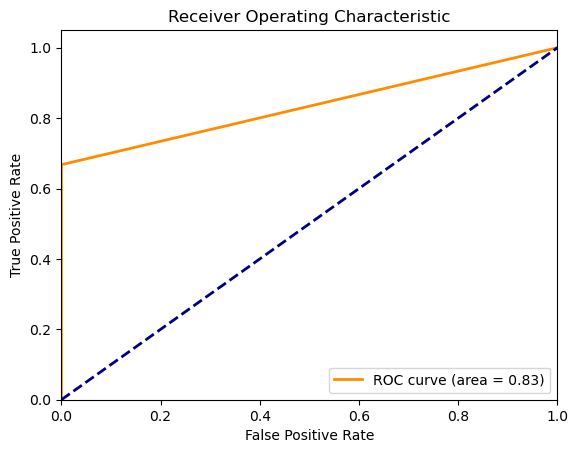

In [ ]:
# auroc

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(result['True_Labels'], result['Predictions'])
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

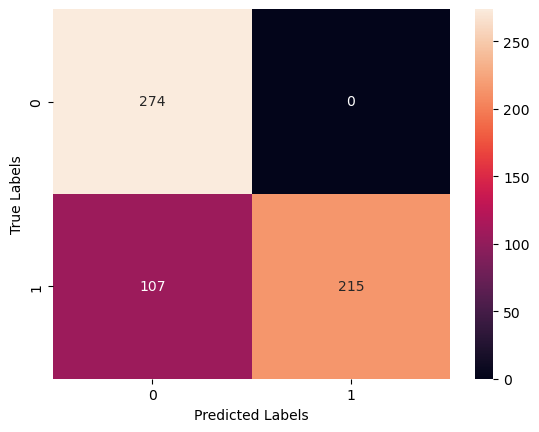

In [ ]:
# Preciction Results heatmap

# Compute confusion matrix
conf_matrix = confusion_matrix(result['True_Labels'], result['Predictions'])

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# precesion
precision = precision_score(result['True_Labels'], result['Predictions'], average='weighted')

# recall
recall = recall_score(result['True_Labels'], result['Predictions'], average='weighted')

# F1 
f1 = f1_score(result['True_Labels'], result['Predictions'], average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Precision: 0.8708890415543694
Recall: 0.8204697986577181
F1 Score: 0.8172475598669415


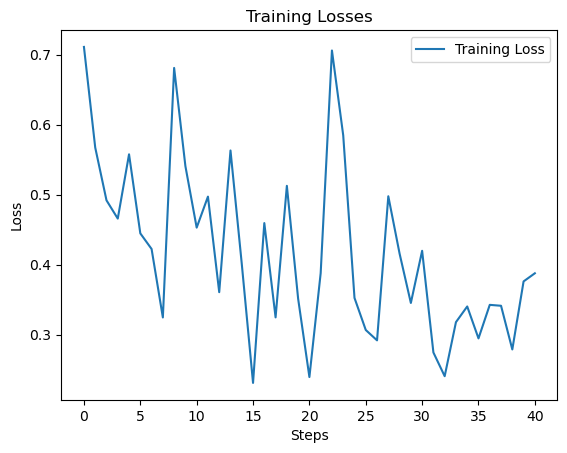

In [ ]:
# training losses Evaluation

train_losses = []
eval_losses = []
for elem in trainer.state.log_history:
      #print(elem)
      if 'loss' in elem.keys():
        train_losses.append(elem['loss'])

# Plot the training and validation losses
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()